## Data and Package Importing

In [1]:
from QC import *
from ml_utils import reorder_adata, gf_icf, recipe_fcc
sc.settings.set_figure_params(dpi=100)

### Load data and preprocess

In [2]:
%time adata = sc.read_h5ad("s1_raw.h5ad")

CPU times: user 10.6 s, sys: 1.86 s, total: 12.4 s
Wall time: 12.4 s


In [3]:
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(adata)

In [4]:
# checkpoint before normalizing and scaling data
adata.raw = adata

In [5]:
%%time
# create new "observations" as percent and mean mito and hemato genes
adata.var['mito'] = adata.var_names.str.startswith('mt-') # identify mitochondrial genes
adata.var['hemato'] = adata.var_names.str.contains('Hbb-bs$|Cd14$|Jchain$|NAGK$') # identify hematopoetic genes

sc.pp.calculate_qc_metrics(adata, qc_vars=['mito','hemato'], inplace=True) # calculate standard qc .obs and .var

adata.obs['mean_mito'] = np.mean(adata[:,adata.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
adata.obs['mean_hemato'] = np.mean(adata[:,adata.var['hemato']].X, axis=1) # add average hematopoetic expression to .obs

CPU times: user 7.98 s, sys: 1.46 s, total: 9.44 s
Wall time: 9.45 s


It's important to examine multiple methods of compiling genes into a single meta-feature, as percents may be biased towards the number of genes used in the summation while means may be thrown off by outliers.

### Find inflection point

Inflection point at index
bcDZZU     4627
bcBTQF     3644
bcAGFS     6859
bcHRFF    13715
Name: total_counts, dtype: int64 for [0, 15, 30, 100] percentiles of greatest secant distances


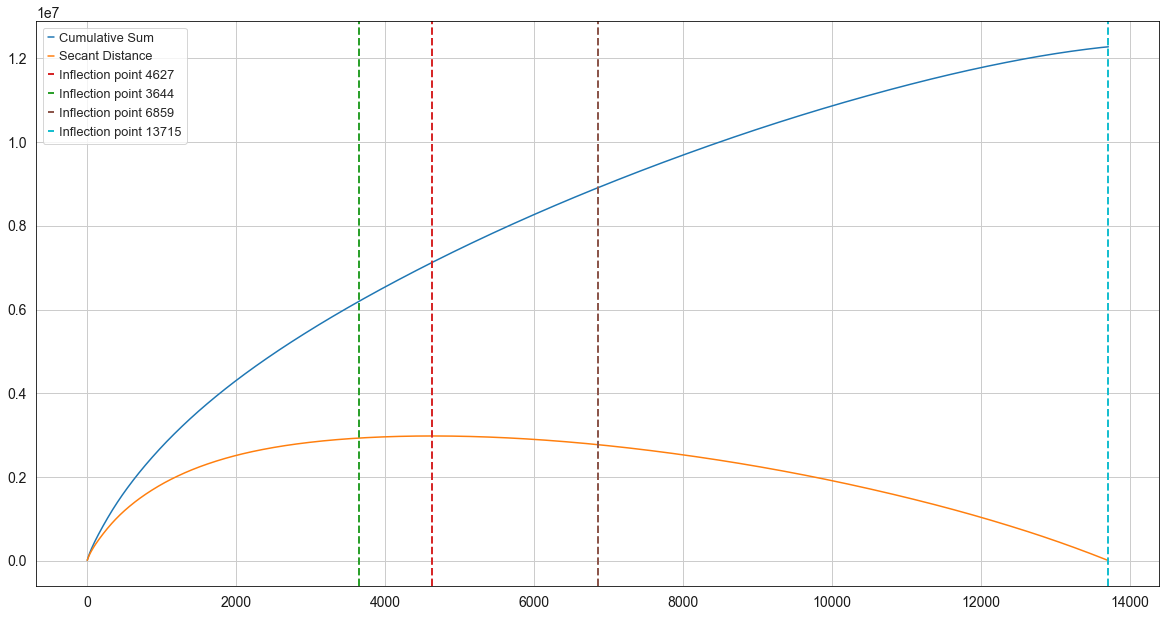

In [6]:
find_inflection(adata)

In [7]:
# filter cells out based on minimum quality
sc.pp.filter_cells(adata, min_counts=adata.obs.iloc[6859].total_counts)

In [8]:
# look at shape and attributes of filtered adata object
# there may be more than the given number of cells depending on cells with the same total_counts value
adata

AnnData object with n_obs × n_vars = 6861 × 80009 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_hemato', 'log1p_total_counts_hemato', 'pct_counts_hemato', 'mean_mito', 'mean_hemato', 'n_counts'
    var: 'mito', 'hemato', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [9]:
# rank cells by total counts and save as .obs
adata.obs['ranked_total_counts'] = np.argsort(adata.obs['total_counts']) 

### Normalize and perform linear dimensionality reduction with PCA

In [10]:
sc.pp.normalize_total(adata, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(adata) # log1p transformation

In [11]:
#same as above but wrapped up in one function and utilizes the arcsinh transform instead of log1p, commented out for convenience
#arcsinh_transform(adata)

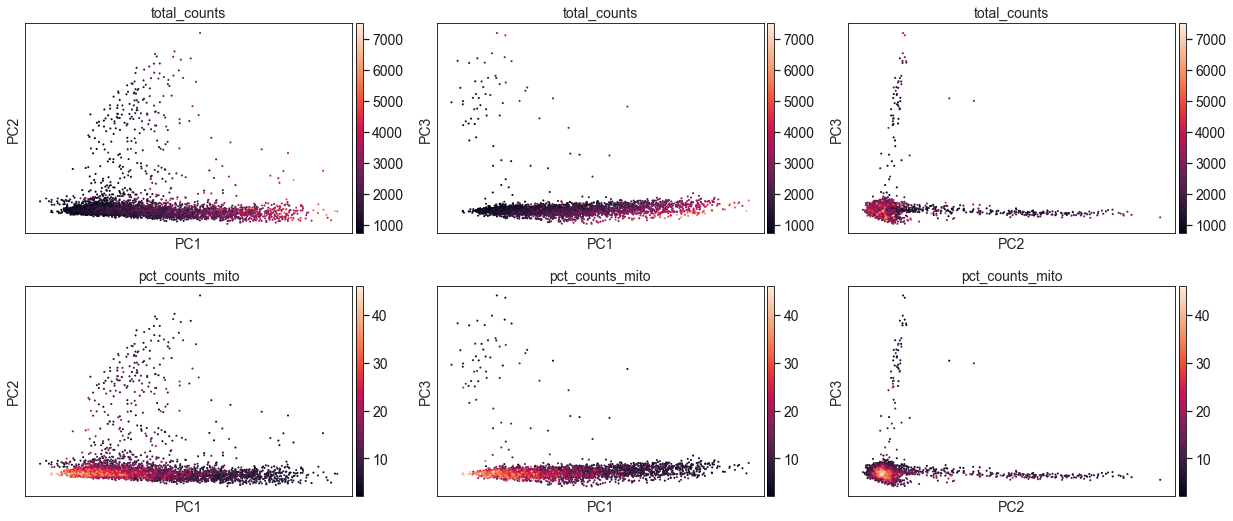

CPU times: user 1min 22s, sys: 4.8 s, total: 1min 27s
Wall time: 18.1 s


In [17]:
%%time
sc.pp.scale(adata, max_value=10) # scaling by variance and centering to zero for visualization
sc.tl.pca(adata, n_comps=100) # perform PCA and plot results
sc.pl.pca(adata, color=['total_counts','pct_counts_mito'], components=['1,2','1,3','2,3'], ncols=3)

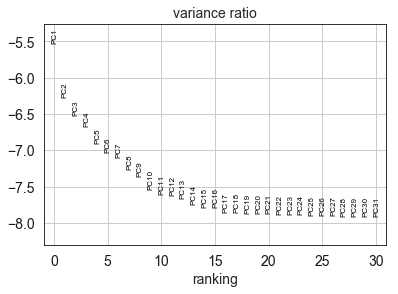

In [18]:
sc.pl.pca_variance_ratio(adata, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [19]:
%%time
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20) #UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.umap(adata) #perform UMAP

CPU times: user 13.8 s, sys: 413 ms, total: 14.2 s
Wall time: 11.7 s


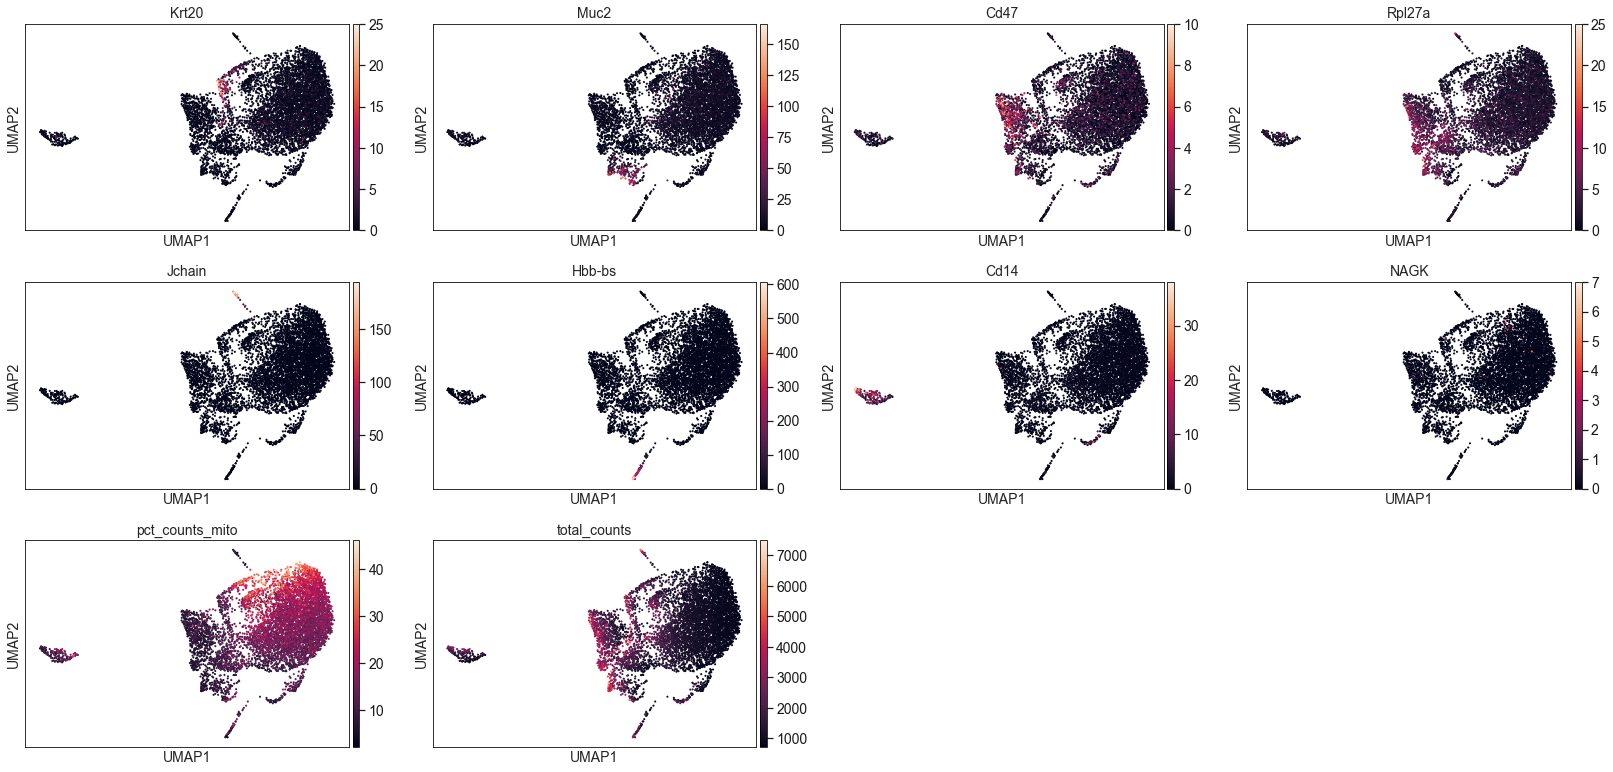

In [20]:
sc.pl.umap(adata,color=['Krt20','Muc2','Cd47','Rpl27a','Jchain','Hbb-bs','Cd14','NAGK','pct_counts_mito','total_counts']) #plot marker genes to determine which clusters to keep or gate out

### Clustering

In [21]:
sc.tl.louvain(adata, resolution=1.6, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

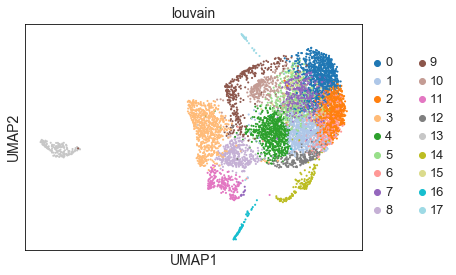

In [22]:
sc.pl.umap(adata, color=['louvain'], wspace=0.5, palette='tab20')

### Cluster quantification and non-parametric testing of gene expression profiles for gating

In [23]:
cluster_summary_stats(adata, raw=False) # in this case it's after normalization, but if you want to find these statistics for the raw counts, set the raw parameter to True

In [24]:
cluster_wilcoxon_rank_sum(adata, ['Krt20','Muc2','Jchain','pct_counts_mito','mean_mito','pct_counts_hemato','mean_hemato'], alternative='greater') 
#this takes a list of features that exist in the normalized representation of the data and performs a wilcoxon rank sum test between each cluster against the global counterparts of those data.
#these features can be single genes or compiled 'metagenes' such as the percent_mito and the mean_mito, as long as their values can be accessed in the AnnData object by using the .obs_vector method
#the "alternative" parameter is passed to scipy's "mann-whitney u" to designate the sidedness of the test, in this case the default is a one-sided hypothesis for values greater than the null.

In [25]:
cluster_p_threshold(adata, 0.05)
#this takes the p-values calculated above (per cluster) and simply returns a binarized output (0 or 1) that can be visualized
#the output represents wether or not the cluster has a p-value below the set threshold (0.05 in this case) 

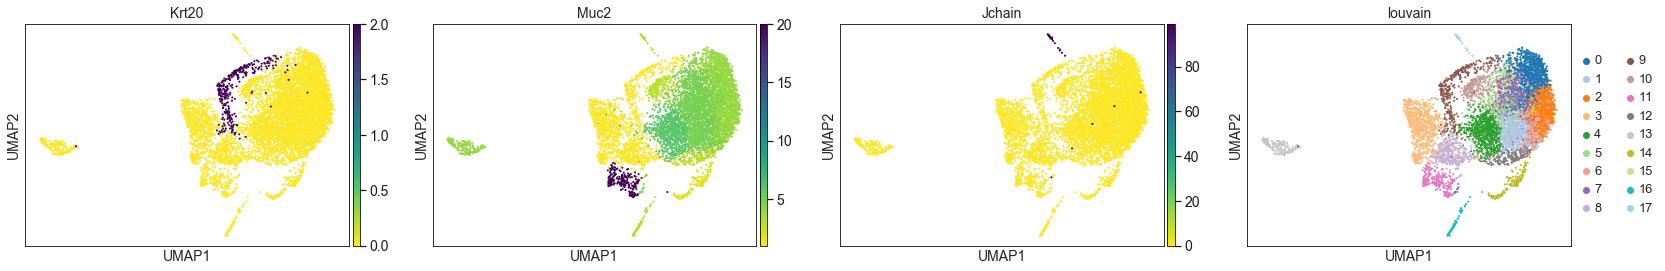

In [26]:
sc.pl.umap(adata, color=['Krt20','Muc2','Jchain','louvain'], color_map='viridis_r', layer='Cluster_Medians') # cluster medians per feature

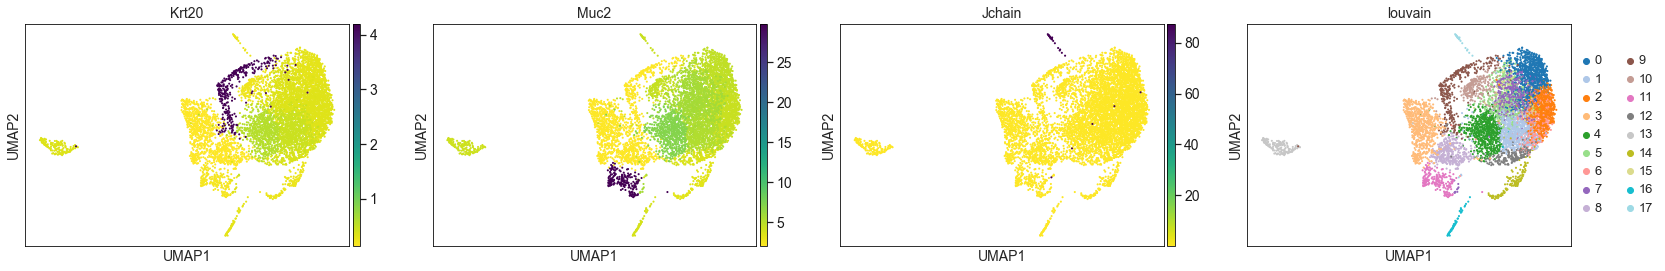

In [27]:
sc.pl.umap(adata, color=['Krt20','Muc2','Jchain','louvain'], color_map='viridis_r', layer='Cluster_Means') # cluster means per feature≤

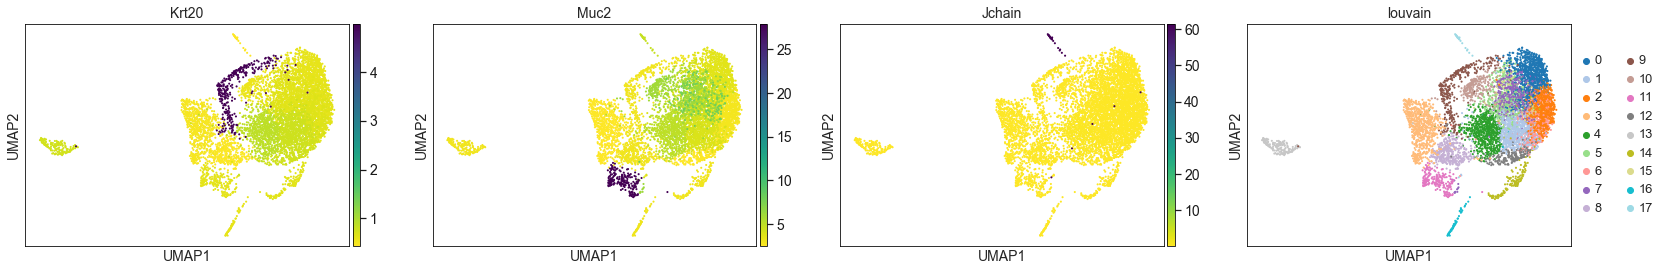

In [28]:
sc.pl.umap(adata, color=['Krt20','Muc2','Jchain','louvain'], color_map='viridis_r', layer='Cluster_Stdevs') # cluster stdevs per feature

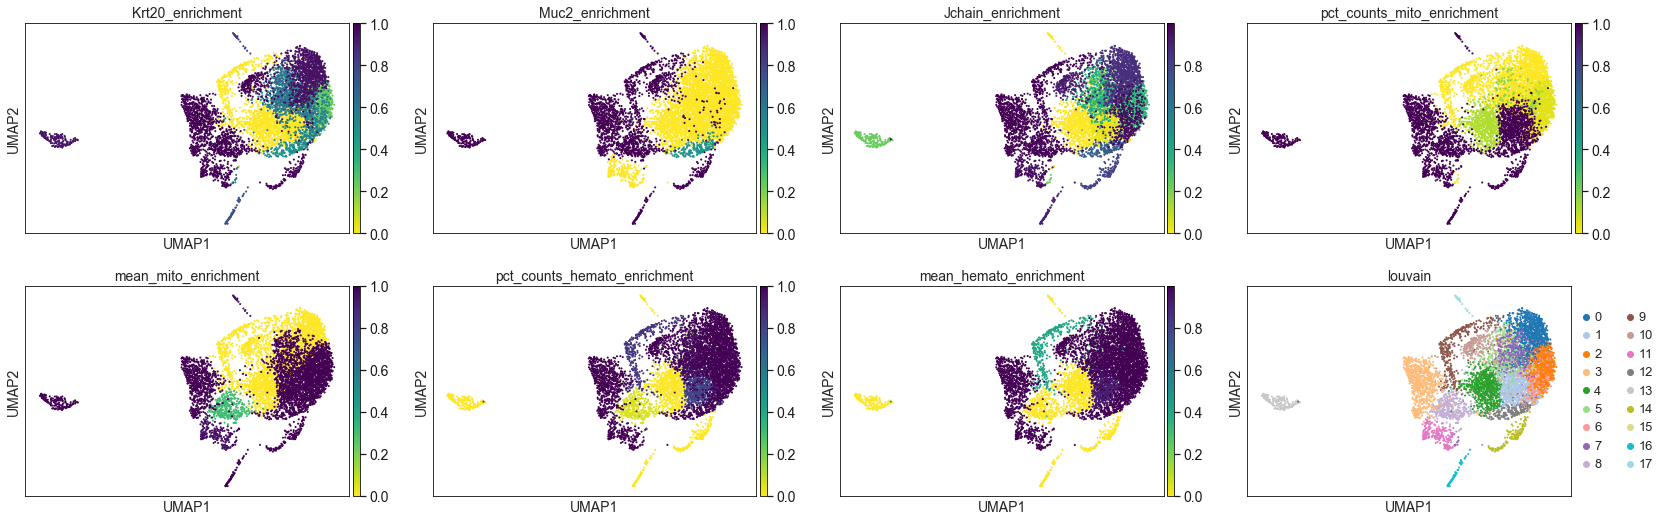

In [29]:
sc.pl.umap(adata, color=['Krt20_enrichment','Muc2_enrichment','Jchain_enrichment','pct_counts_mito_enrichment','mean_mito_enrichment',
                         'pct_counts_hemato_enrichment','mean_hemato_enrichment','louvain'], color_map='viridis_r')
# these are simply the p-values resulting from the features/featuresets tested, this visualization just shows a continuum of p-values per cluster given that test

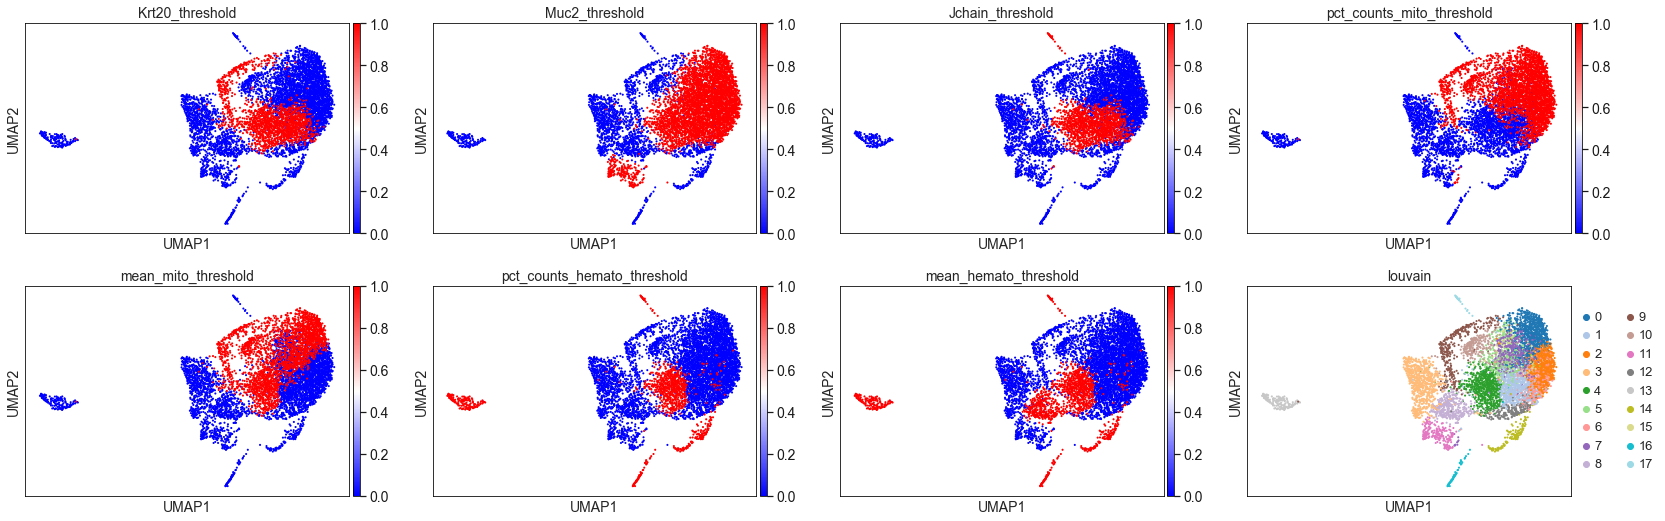

In [31]:
sc.pl.umap(adata, color=['Krt20_threshold','Muc2_threshold','Jchain_threshold','pct_counts_mito_threshold','mean_mito_threshold',
                         'pct_counts_hemato_threshold','mean_hemato_threshold','louvain'], color_map = 'bwr')
# similar to above, but with significance threholded at 0.05 as per the example, this gives us a better idea of which louvain clusters to gate out based off of statistical bases

The above overlays are simply to guide the louvain cluster gating process by providing more quantitative and statistically robust methods for determining which clusters to gate out  

In [32]:
to_keep = np.where(adata.obs['louvain'].isin(['3','4','8','9','11','12','13','14','16','17']))[0] # fill in the indices of the clusters you want to keep here
# we choose these to keep because all other clusters have a significant enrichment for mitochondrial genes or hematopoetic cells

In [33]:
adata_filtered = sc.AnnData(adata.raw.X[to_keep,:]) # subsetting the original data to make a filtered dataset, here, we subset the raw (.raw) count data for our new object/QC'd dataset
adata_filtered.obs = pd.DataFrame(adata.obs.iloc[to_keep,:]['n_counts']) # subsetting the original data to make a filtered dataset
adata_filtered.var = adata.var # transferring variable/feature names 

In [34]:
adata_filtered # quick check of reduced/filtered dataset properties
# note that this example does NOT transfer over the calculated observations (though possible), this is simply to simplify the object for downstream analysis, a "fresh start" in a way
# this object simply contains a subset of cells and their gene counts given the starting dataset with no further calculated features outside of n_counts

AnnData object with n_obs × n_vars = 2852 × 80009 
    obs: 'n_counts'
    var: 'mito', 'hemato', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [35]:
adata_filtered.write_h5ad("s1_filtered.h5ad",compression='gzip') # optional saving results to file as compressed .h5ad 